### 1. imports

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

### 2. 다항분류 

#### A. 이항분류와 `BCEWithLogitsLoss`

`-` 데이터

In [4]:
#train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
to_tensor = torchvision.transforms.ToTensor()
X0_train = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==0])
X1_train = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==1])
X = torch.concat([X0_train,X1_train],axis=0).reshape(-1,784)
y = torch.tensor([0.0]*len(X0_train) + [1.0]*len(X1_train)).reshape(-1,1)

`-` 예전에 적합했던 코드에서 sig를 분리한것

In [5]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
)
sig = torch.nn.Sigmoid()
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(1,31):
    #1
    netout = net(X)
    yhat = sig(netout)
    #2
    loss = loss_fn(yhat,y)
    #3
    loss.backward()
    #4 
    optimizr.step()
    optimizr.zero_grad()

`-` netout(=logits) 의 특징

-   $netout >0 \Leftrightarrow sig(netout) > 0.5$
-   $netout <0 \Leftrightarrow sig(netout) < 0.5$

In [6]:
((net(X)>0) ==y).float().mean()

tensor(0.9956)

`-` 아래의 코드는 위의 코드와 같은 코드임

* 이렇게 하면 약간의 계산상의 이득

In [7]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(1,31):
    #1
    netout = net(X) 
    #2
    loss = loss_fn(netout,y)
    #3
    loss.backward()
    #4 
    optimizr.step()
    optimizr.zero_grad()

#### B. 범주형 자료의 변환

`-` 범주형자료를 숫자로 어떻게 바꿀까?

-   실패 / 성공 $\to$ 0 / 1
-   숫자0그림 / 숫자1그림 $\to$ 0 / 1
-   강아지그림 / 고양이그림 $\to$ 0 / 1
-   강아지그림 / 고양이그림 / 토끼그림 $\to$ 0 / 1 / 2 ?????

`-` 주입식교육: 강아지그림/고양이그림/토끼그림일 경우 숫자화시키는 방법

-   잘못된방식: 강아지그림 = 0, 고양이그림 = 1, 토끼그림 = 2
-   올바른방식: 강아지그림 = \[1,0,0\], 고양이그림 = \[0,1,0\], 토끼그림
    = \[0,0,1\] \### \<– 이런방식을 `원핫인코딩`이라함

`-` 왜?

-   설명1: 강아지그림, 고양이그림, 토끼그림은 서열측도가 아니라
    명목척도임. 그래서 범주를 0,1,2 로 숫자화하면 평균등의 의미가 없음
    (사회조사분석사 2급 스타일)
-   설명2: 범주형은 원핫인코딩으로 해야함 (“30일만에 끝내는
    실전머신러닝” 이런 책에 나오는 스타일)
-   설명3: 동전을 한번 던져서 나오는 결과는 $n=1$인 이항분포를 따름.
    주사위 한번 던져서 나오는 눈금의 숫자는 $n=1$인 다항분포를 따름.
    $n=1$인 이항분포의 실현값은 0,1 이고, $n=1$인 다항분포의 실현값은
    \[1,0,0\], \[0,1,0\], \[0,0,1\] 이므로 당연히 $y_i$ 는 \[1,0,0\],
    \[0,1,0\], \[0,0,1\] 중 하나의 형태를 가진다고 가정하는게 바람직함
    (이 설명이 이 중에서 가장 정확한 설명임)

## C. 실습: 3개의 클래스를 구분

`-` 데이터준비

In [8]:
#train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
to_tensor = torchvision.transforms.ToTensor()
X0 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==0])
X1 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==1])
X2 = torch.stack([to_tensor(Xi) for Xi, yi in train_dataset if yi==2])
X = torch.concat([X0,X1,X2]).reshape(-1,1*28*28)
y = torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2)).reshape(-1,1).float()

In [9]:
y = torch.nn.functional.one_hot(y.reshape(-1).long()).float()
y

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])

`-` 적합

In [10]:
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,3),
)
loss_fn = torch.nn.CrossEntropyLoss() # 의미상 CEWithLogitsLoss
optimizr = torch.optim.Adam(net.parameters())
for epoc in range(1,31):
    #1
    netout = net(X) # netout: (n,3) 
    #2
    loss = loss_fn(netout,y) 
    #3
    loss.backward()
    #4 
    optimizr.step()
    optimizr.zero_grad()

In [11]:
(netout.argmax(axis=1) == y.argmax(axis=1)).float().mean()

tensor(0.9685)

In [13]:
torch.exp(netout)

tensor([[35.0634,  0.2371,  0.1590],
        [35.9059,  0.2793,  0.1412],
        [ 4.8449,  0.4623,  0.4364],
        ...,
        [ 1.1820,  0.2359,  3.2423],
        [ 0.3119,  0.1862, 15.4971],
        [ 0.4304,  0.4113,  5.2896]], grad_fn=<ExpBackward0>)

#### D. 결론

`-` 파이토치버전 // 코딩용

|   분류   | netout의 의미 |      손실함수       |
|:--------:|:-------------:|:-------------------:|
| 이항분류 |     prob      |      `BCELoss`      |
| 이항분류 |     logit     | `BCEWithLogitsLoss` |
| 다항분류 |     probs     |         NA          |
| 다항분류 |    logits     | `CrossEntropyLoss`  |

> `CrossEntropyLoss` 이거 이름이 완전 마음에 안들어요..
> `CEWithLogitsLoss` 라고 하는게 더 좋을 것 같습니다.

`-` 일반적개념 // 이론용

|   분류   | 오차항의가정 | 마지막활성화함수 |       손실함수       |
|:--------:|:------------:|:----------------:|:--------------------:|
| 이항분류 |   이항분포   |    sigmoid[1]    | Binary Cross Entropy |
| 다항분류 |   다항분포   |    softmax[2]    |    Cross Entropy     |

`-` 참고 (sigmoid, softmax 계산과정비교)

-   $prob = \text{sig}(logit) =\frac{\exp(logit)}{1+\exp(logit)}$
-   $probs= \text{softmax}\left(\begin{bmatrix} logit_1 \\ logit_2 \\ logit_3\end{bmatrix}\right) =\begin{bmatrix} \frac{\exp(logit_1)}{\exp(logit_1)+\exp(logit_2)+\exp(logit_3)} \\
    \frac{\exp(logit_2)}{\exp(logit_1)+\exp(logit_2)+\exp(logit_3)} \\
    \frac{\exp(logit_3)}{\exp(logit_1)+\exp(logit_2)+\exp(logit_3)} \end{bmatrix}$

### 3. FashionMNIST

#### A. 데이터

<https://arxiv.org/abs/1708.07747> (Xiao, Rasul, and Vollgraf 2017)

[1] prob=sig(logit)

[2] probs=soft(logits)

In [15]:
#train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
#test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)
to_tensor = torchvision.transforms.ToTensor()
X = torch.stack([to_tensor(img) for img, lbl in train_dataset])
y = torch.tensor([lbl for img, lbl in train_dataset])
y = torch.nn.functional.one_hot(y).float()
XX = torch.stack([to_tensor(img) for img, lbl in test_dataset])
yy = torch.tensor([lbl for img, lbl in test_dataset])
yy = torch.nn.functional.one_hot(yy).float()

In [19]:
torchvision.datasets.FashionMNIST.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

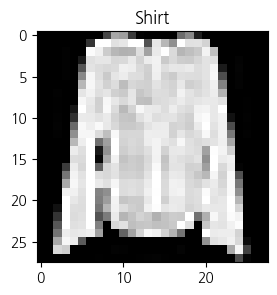

In [18]:
obs_idx = 301
plt.imshow(X[obs_idx,0,:,:],cmap="gray")
plt.title(torchvision.datasets.FashionMNIST.classes[y[obs_idx,:].argmax().item()]);

#### B. 간단한 신경망

In [20]:
ds_train = torch.utils.data.TensorDataset(X,y)
dl_train = torch.utils.data.DataLoader(ds_train,batch_size=256,shuffle=True)
ds_test = torch.utils.data.TensorDataset(XX,yy)
dl_test = torch.utils.data.DataLoader(ds_test,batch_size=256)

`-` Step2: 학습에 필요한 준비 (모델링)

`-` 직접 만들기

In [30]:
class Flatten(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, inp):
        out = inp.reshape(-1,784)
        return out

In [31]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    Flatten(),#torch.nn.Flatten(),
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,10)
).to("cuda:0")
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
#---#

`-` torch 기능 사용

In [ ]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,10)
).to("cuda:0")
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
#---#

`-` Step3: 적합

In [32]:
for epoc in range(1,31):
    net.train()
    #---에폭시작---#
    for Xm,ym in dl_train:        
        Xm = Xm.to("cuda:0")
        ym = ym.to("cuda:0")
        # 1
        netout = net(Xm)
        # 2 
        loss = loss_fn(netout,ym)
        # 3 
        loss.backward()
        # 4 
        optimizr.step()
        optimizr.zero_grad()
    #---에폭끝---#
    if epoc % 5 == 0:
        net.eval()
        s =0
        for Xm,ym in dl_train:        
            Xm = Xm.to("cuda:0")
            ym = ym.to("cuda:0")        
            logits = net(Xm).data 
            s = s+ (logits.argmax(axis=1) == ym.argmax(axis=1)).float().sum()
        acc = s / len(X)
        print(f"# of epochs = {epoc},train_acc = {acc:.4f}") 

# of epochs = 5,train_acc = 0.8588
# of epochs = 10,train_acc = 0.8659
# of epochs = 15,train_acc = 0.8779
# of epochs = 20,train_acc = 0.8831
# of epochs = 25,train_acc = 0.8856
# of epochs = 30,train_acc = 0.8876


`-` Step4: 적합결과 시각화 및 분석

In [33]:
net.eval()
s =0
for Xm,ym in dl_test:        
    Xm = Xm.to("cuda:0")
    ym = ym.to("cuda:0")        
    logits = net(Xm).data 
    s = s+ (logits.argmax(axis=1) == ym.argmax(axis=1)).float().sum()
acc = s / len(XX)
print(f"test_acc = {acc:.4f}") 

test_acc = 0.8638


#### C. 약간 더 복잡한 신경망

In [34]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784,256),
    torch.nn.ReLU(),
    torch.nn.Linear(256,10)
).to("cuda:0")
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
#---#

In [35]:
for epoc in range(1,31):
    net.train()
    #---에폭시작---#
    for Xm,ym in dl_train:        
        Xm = Xm.to("cuda:0")
        ym = ym.to("cuda:0")
        # 1
        netout = net(Xm)
        # 2 
        loss = loss_fn(netout,ym)
        # 3 
        loss.backward()
        # 4 
        optimizr.step()
        optimizr.zero_grad()
    #---에폭끝---#
    if epoc % 5 == 0:
        net.eval()
        s =0
        for Xm,ym in dl_train:        
            Xm = Xm.to("cuda:0")
            ym = ym.to("cuda:0")        
            logits = net(Xm).data 
            s = s+ (logits.argmax(axis=1) == ym.argmax(axis=1)).float().sum()
        acc = s / len(X)
        print(f"# of epochs = {epoc},train_acc = {acc:.4f}") 

# of epochs = 5,train_acc = 0.8843
# of epochs = 10,train_acc = 0.9020
# of epochs = 15,train_acc = 0.9176
# of epochs = 20,train_acc = 0.9265
# of epochs = 25,train_acc = 0.9345
# of epochs = 30,train_acc = 0.9388


In [36]:
net.eval()
s =0
for Xm,ym in dl_test:        
    Xm = Xm.to("cuda:0")
    ym = ym.to("cuda:0")        
    logits = net(Xm).data 
    s = s+ (logits.argmax(axis=1) == ym.argmax(axis=1)).float().sum()
acc = s / len(XX)
print(f"test_acc = {acc:.4f}") 

test_acc = 0.8892


#### D. 발악..?

`-` 노드를 엄청 많이...

In [37]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784,4096),
    torch.nn.Dropout(0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(4096,10)
).to("cuda:0")
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
#---#

In [38]:
for epoc in range(1,31):
    net.train()
    #---에폭시작---#
    for Xm,ym in dl_train:        
        Xm = Xm.to("cuda:0")
        ym = ym.to("cuda:0")
        # 1
        netout = net(Xm)
        # 2 
        loss = loss_fn(netout,ym)
        # 3 
        loss.backward()
        # 4 
        optimizr.step()
        optimizr.zero_grad()
    #---에폭끝---#
    if epoc % 5 == 0:
        net.eval()
        s =0
        for Xm,ym in dl_train:        
            Xm = Xm.to("cuda:0")
            ym = ym.to("cuda:0")        
            logits = net(Xm).data 
            s = s+ (logits.argmax(axis=1) == ym.argmax(axis=1)).float().sum()
        acc = s / len(X)
        print(f"# of epochs = {epoc},train_acc = {acc:.4f}") 

# of epochs = 5,train_acc = 0.8870
# of epochs = 10,train_acc = 0.9024
# of epochs = 15,train_acc = 0.9116
# of epochs = 20,train_acc = 0.9214
# of epochs = 25,train_acc = 0.9302
# of epochs = 30,train_acc = 0.9307


In [39]:
net.eval()
s =0
for Xm,ym in dl_test:        
    Xm = Xm.to("cuda:0")
    ym = ym.to("cuda:0")        
    logits = net(Xm).data 
    s = s+ (logits.argmax(axis=1) == ym.argmax(axis=1)).float().sum()
acc = s / len(XX)
print(f"test_acc = {acc:.4f}") 

test_acc = 0.8913


`-` 레이어를 많이..

In [40]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784,256),
    torch.nn.ReLU(),
    torch.nn.Linear(256,256),
    torch.nn.ReLU(),
    torch.nn.Linear(256,256),
    torch.nn.ReLU(), 
    torch.nn.Linear(256,256),
    torch.nn.ReLU(),    
    torch.nn.Linear(256,10)
).to("cuda:0")
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
#---#

In [41]:
for epoc in range(1,31):
    net.train()
    #---에폭시작---#
    for Xm,ym in dl_train:        
        Xm = Xm.to("cuda:0")
        ym = ym.to("cuda:0")
        # 1
        netout = net(Xm)
        # 2 
        loss = loss_fn(netout,ym)
        # 3 
        loss.backward()
        # 4 
        optimizr.step()
        optimizr.zero_grad()
    #---에폭끝---#
    if epoc % 5 == 0:
        net.eval()
        s =0
        for Xm,ym in dl_train:        
            Xm = Xm.to("cuda:0")
            ym = ym.to("cuda:0")        
            logits = net(Xm).data 
            s = s+ (logits.argmax(axis=1) == ym.argmax(axis=1)).float().sum()
        acc = s / len(X)
        print(f"# of epochs = {epoc},train_acc = {acc:.4f}") 

# of epochs = 5,train_acc = 0.8881
# of epochs = 10,train_acc = 0.9154
# of epochs = 15,train_acc = 0.9240
# of epochs = 20,train_acc = 0.9303
# of epochs = 25,train_acc = 0.9511
# of epochs = 30,train_acc = 0.9547


In [42]:
net.eval()
s =0
for Xm,ym in dl_test:        
    Xm = Xm.to("cuda:0")
    ym = ym.to("cuda:0")        
    logits = net(Xm).data 
    s = s+ (logits.argmax(axis=1) == ym.argmax(axis=1)).float().sum()
acc = s / len(XX)
print(f"test_acc = {acc:.4f}") 

test_acc = 0.8907


`-` test_acc 를 90% 넘기는게 힘들다..

#### F. 합성곱신경망

In [43]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1 ,out_channels=64,kernel_size=5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),
    torch.nn.Conv2d(in_channels=64 ,out_channels=64,kernel_size=5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=2),    
    torch.nn.Flatten(),
    torch.nn.Linear(1024,10)
).to("cuda:0")
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
#---#

In [44]:
for epoc in range(1,31):
    net.train()
    #---에폭시작---#
    for Xm,ym in dl_train:        
        Xm = Xm.to("cuda:0")
        ym = ym.to("cuda:0")
        # 1
        netout = net(Xm)
        # 2 
        loss = loss_fn(netout,ym)
        # 3 
        loss.backward()
        # 4 
        optimizr.step()
        optimizr.zero_grad()
    #---에폭끝---#
    if epoc % 5 == 0:
        net.eval()
        s =0
        for Xm,ym in dl_train:        
            Xm = Xm.to("cuda:0")
            ym = ym.to("cuda:0")        
            logits = net(Xm).data 
            s = s+ (logits.argmax(axis=1) == ym.argmax(axis=1)).float().sum()
        acc = s / len(X)
        print(f"# of epochs = {epoc},train_acc = {acc:.4f}") 

# of epochs = 5,train_acc = 0.9067
# of epochs = 10,train_acc = 0.9322
# of epochs = 15,train_acc = 0.9420
# of epochs = 20,train_acc = 0.9579
# of epochs = 25,train_acc = 0.9653
# of epochs = 30,train_acc = 0.9772


In [45]:
net.eval()
s =0
for Xm,ym in dl_test:        
    Xm = Xm.to("cuda:0")
    ym = ym.to("cuda:0")        
    logits = net(Xm).data 
    s = s+ (logits.argmax(axis=1) == ym.argmax(axis=1)).float().sum()
acc = s / len(XX)
print(f"test_acc = {acc:.4f}") 

test_acc = 0.9166
